In [7]:
import numpy as np
import pandas as pd
import scipy.io as sio

import processAc_tomo_funcs as pytomo
import pylook_extra as lc2
import h5py as h5

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib widget
# from sideblock_distances import DistanceSensorsVessel
# from ac_res_anlys_funcs import pickTOF

from bokeh.plotting import figure, show, save
from bokeh.io import output_notebook, output_file, reset_output
from bokeh.layouts import gridplot, row, column
output_notebook()

Loading BokehJS ...

In [2]:
def TSplot(idxAc, Time, effNS, ThChangeLPF, TimeShift, T, R, runname, run, SAVE):

    fig11 = figure(tools='pan,box_zoom,undo,hover') #, y_axis_type="log" , 
    fig11.line(Time[idxAc], effNS[idxAc], line_width = 1.5, line_color="crimson")
    fig11.yaxis.axis_label = 'effNS (MPa)'

    fig12 = figure(x_range=fig11.x_range, tools='pan,box_zoom,undo,save,hover')
    fig12.line(Time[idxAc], ThChangeLPF[idxAc], line_width=1.5, line_color="black")
    fig12.yaxis.axis_label = 'Norm. Disp. (um)'

    fig13 = figure(title='T'+str(T+1)+' --> R'+str(R+1),x_range=fig11.x_range, tools='pan,box_zoom,undo,save,hover')
    fig13.line(Time[idxAc], TimeShift[:,R,T], line_width=1.5, line_color="mediumblue")
    fig13.yaxis.axis_label = 'Time Shift (us)'
    fig13.xaxis.axis_label = 'Time (s)'

    fig1 = gridplot([fig11, fig12, fig13], ncols=1, plot_width=800, plot_height=333)
    
    # if SAVE == 1:
    #     reset_output()
    #     filename = '../Results_wAmp/'+runname+'_'+run+'_timeshift_unFilt_T'+str(T+1)+'R'+str(R+1)
    #     output_file(filename+'.html')
    #     save(fig1)
    #     show(fig1, notebook_handle=True)
    # else: 
    # reset_output()
    # output_notebook()
    show(fig1)
    
    
def pickTOF(idx2analyze, T, R, Nsamples, fs, fullWFref, runname, run, SAVE):

    # winanalysis = idx2analyze[:,R,T];
    timeWF = np.arange(Nsamples)/fs
    # partWFref = np.full(Nsamples, np.nan)
    # partWFref[winanalysis[0]:winanalysis[1]] = fullWFref[winanalysis[0]:winanalysis[1],R,T]

    """figure used to pick arrival by hand"""
    
    fig, axs = plt.subplots(1, 1, figsize=(12, 6), sharex=True)
    axs.plot(timeWF, fullWFref[:,R,T], color='k')
    # axs.plot(timeWF, partWFref, color='crimson')
    axs.set_ylabel("Reference WF (.)") 
    axs.set_xlabel('Time ($\mu s$)')
    plt.tight_layout()
    plt.show()
    
    return timeWF

In [3]:
SAVE = 0
runname = 'p5741'
acousticrun = 'run1'
AcSettingsfile = "../acData/"+runname+"_"+acousticrun+".mat"

T = 0
R = 0

In [4]:
numSFpfile, numWFpSFpCH, numWFpfilepCH, numCHR, numCHT, WFlength, sampFreq = pytomo.loadACsettings(AcSettingsfile)

In [36]:
def getAcResults(fileName, chanName):
    return np.array(h5.File(fileName, "r")[chanName])

fileName = "./Results_p5741_run19774.471956568916s-10605.742634563065s_Stack5WFs_absrefw_Amp.hdf5"

datakeys = ["MaxInter", "TimeShift", "RmsAmp", "Amp", "RmsAmpRef", 
"AmpRef", "fullWFref", "LocalAcTime", "freqQAmp", "maxAmp", "maxFreq"]

[MaxInter, TimeShift, RmsAmp, Amp, RmsAmpRef, AmpRef, fullWFref, LocalAcTime, freqQAmp, maxAmp, maxFreq] = list(map(lambda x: getAcResults(fileName, datakeys[x]), np.arange(len(datakeys))))

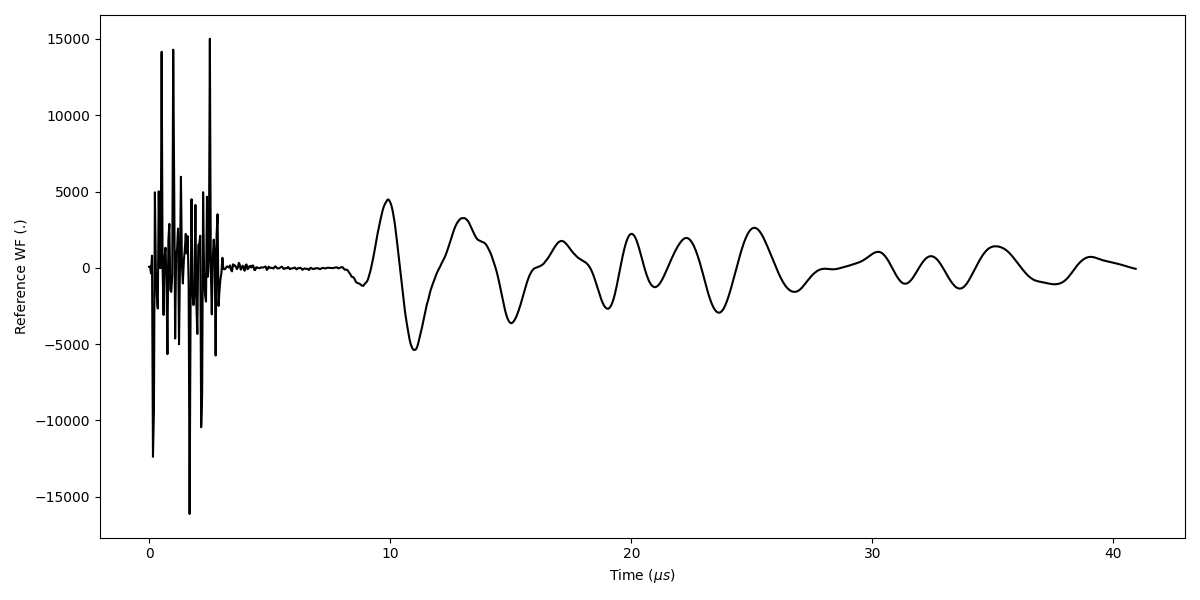

In [11]:
timeWF = pickTOF("idx2analyze", T, R, WFlength, sampFreq, fullWFref, "runname", "run", SAVE=0)

In [58]:
# fullWFref[0:100,R,T] = 0 # zero electrical noise that precedes all WFs

AIC = np.zeros(len(fullWFref[:,R,T]))

for j in range(len(fullWFref[:,R,T])):
    AIC[j] = j*np.log10(np.var(fullWFref[0:j,R,T]))+(len(fullWFref[:,R,T])-j-1)*np.log10(np.var(fullWFref[j+1:len(fullWFref[:,R,T]),R,T]));

AIC[AIC == -np.inf] = np.nanmax(AIC)
AIC[len(fullWFref[:,R,T])-1] = np.nanmax(AIC)

AIC_min = np.nanmin(AIC)
AIC_max = np.nanmax(AIC)
AIC_idx = (AIC == AIC_min)

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/1n/n60h7ryd3bv7y8pq1wmdvfyh0000gn/T/ipykernel_67455/2477053598.py:6: RuntimeWarning: divide by zero encountered in log10
  AIC[j] = j*np.log10(np.var(fullWFref[0:j,R,T]))+(len(fullWFref[:,R,T])-j-1)*np.log10(np.var(fullWFref[j+1:len(fullWFref[:,R,T]),R,T]));


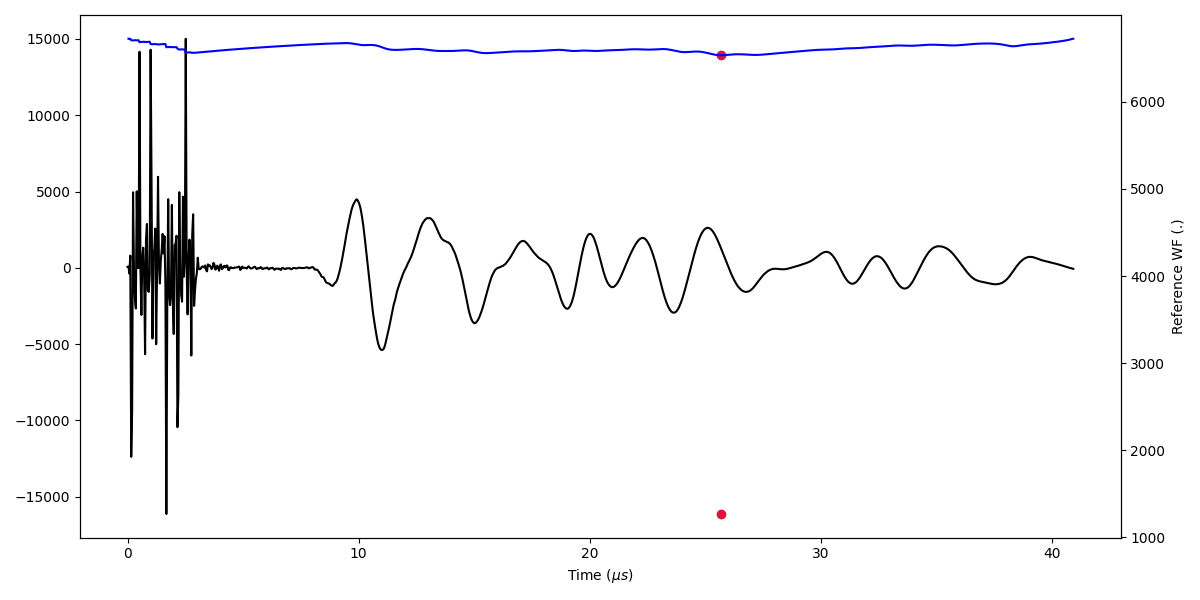

In [59]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6), sharex=True)
axs.plot(timeWF, fullWFref[:,R,T], color='k')
axs2 = axs.twinx()
axs2.plot(timeWF, AIC, color="blue")
axs2.scatter(timeWF[AIC_idx], AIC_min, color="crimson")
axs2.scatter(timeWF[AIC_idx], fullWFref[AIC_idx,R,T], color="crimson")
axs2.set_ylabel("Reference WF (.)") 
axs.set_xlabel('Time ($\mu s$)')
plt.tight_layout()
plt.show()

In [31]:
def classic_sta_lta_py(a, nsta, nlta):
    """
    Computes the standard STA/LTA from a given input array a. The length of
    the STA is given by nsta in samples, respectively is the length of the
    LTA given by nlta in samples. Written in Python.
    .. note::
        There exists a faster version of this trigger wrapped in C
        called :func:`~obspy.signal.trigger.classic_sta_lta` in this module!
    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of short time average window in samples
    :type nlta: int
    :param nlta: Length of long time average window in samples
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Characteristic function of classic STA/LTA
    """
    # The cumulative sum can be exploited to calculate a moving average (the
    # cumsum function is quite efficient)
    sta = np.cumsum(a ** 2)

    # Convert to float
    # sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[nsta:] = sta[nsta:] - sta[:-nsta]
    sta /= nsta
    lta[nlta:] = lta[nlta:] - lta[:-nlta]
    lta /= nlta

    # Pad zeros
    sta[:nlta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [72]:
sta_lta = classic_sta_lta_py(fullWFref[:,R,T], 5, 120)

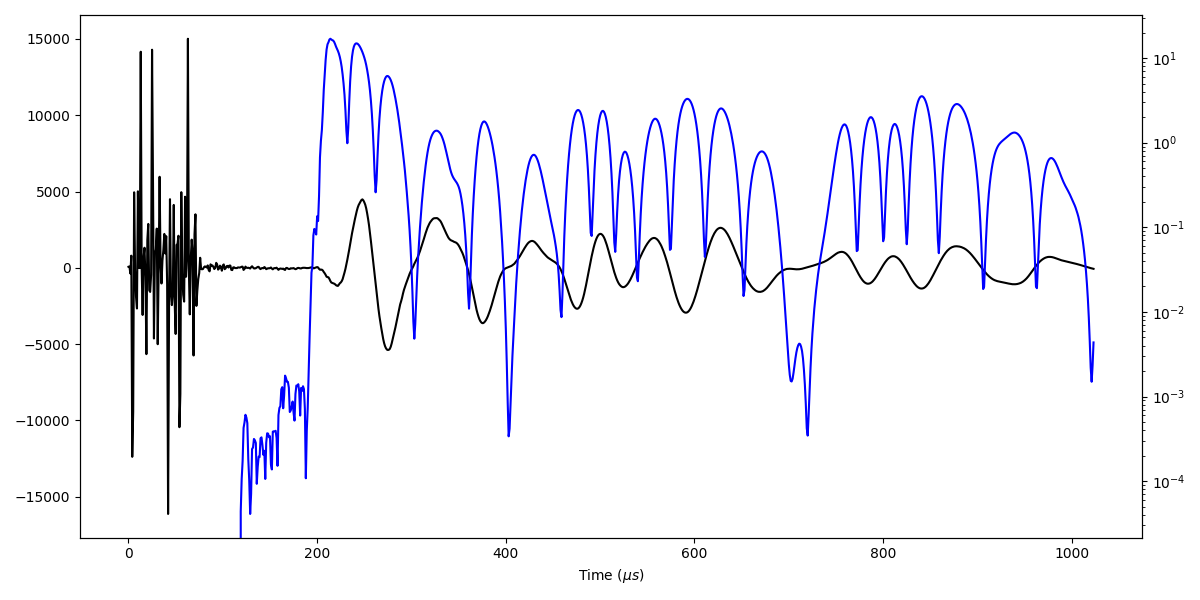

In [77]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6), sharex=True)
axs.plot(fullWFref[:,R,T], color='k')
axs2 = axs.twinx()
axs2.plot(sta_lta, color="blue")
axs2.set_yscale("log")
# axs2.scatter(timeWF[AIC_idx], AIC_min, color="crimson")
# axs.scatter(timeWF[AIC_idx], fullWFref[AIC_idx,R,T], color="crimson")
# axs2.set_ylabel("Reference WF (.)") 
axs.set_xlabel('Time ($\mu s$)')
plt.tight_layout()
plt.show()

In [75]:
sta_lta[190:220]

array([7.28367117e-04, 2.02171073e-03, 5.05028018e-03, 1.19388526e-02,
       2.90581661e-02, 3.52065746e-02, 7.99912667e-02, 9.56710809e-02,
       9.22721332e-02, 8.21272405e-02, 1.34954170e-01, 1.18458643e-01,
       2.33222899e-01, 6.71947574e-01, 1.05327800e+00, 1.40902288e+00,
       2.29428876e+00, 4.19158540e+00, 6.47095072e+00, 9.52017429e+00,
       1.26204375e+01, 1.45445713e+01, 1.53690856e+01, 1.65482838e+01,
       1.69163989e+01, 1.65862027e+01, 1.62857634e+01, 1.61181847e+01,
       1.55454351e+01, 1.46552585e+01])